In [1]:
%load_ext autoreload
%autoreload

#!nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

import matplotlib.pyplot as plt

import json
import numpy

In [2]:
import LFPy
print(LFPy.__file__)

/gpfs/bbp.cscs.ch/home/damart/myenv/lib/python3.7/site-packages/LFPy/__init__.py


In [3]:
# Define electrode parameters
X, Y = numpy.mgrid[-80:81:50, -80:81:50]
Z = numpy.zeros(X.shape)

electrode_params = {
    'sigma' : 0.3,      # extracellular conductivity
    'x' : X.flatten(),  # electrode requires 1d vector of positions
    'y' : Y.flatten(),
    'z' : Z.flatten()
}

electrode = LFPy.RecExtElectrode(**electrode_params)

In [4]:
import l5pc_model
import l5pc_evaluator

morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
param_configs = json.load(open('config/parameters.json'))
parameters = l5pc_model.define_parameters()
mechanisms = l5pc_model.define_mechanisms()

l5pc_cell = ephys.models.LFPyCellModel('l5pc', 
                                       v_init=-65., 
                                       morph=morphology, 
                                       mechs=mechanisms, 
                                       params=parameters)

param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

fitness_protocols = l5pc_evaluator.define_protocols()
feature_configs = json.load(open('config/features.json'))
fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols)

sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, electrode=electrode)
#sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, electrode=None)
evaluator = ephys.evaluators.CellEvaluator(                                          
                cell_model=l5pc_cell,                                                       
                param_names=param_names,                                                    
                fitness_protocols=fitness_protocols,                                        
                fitness_calculator=fitness_calculator,                                      
                sim=sim) 

In [5]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}

In [6]:
release_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), 
                                            param_values=release_params)

Bla
72.74035358428955
(16, 24001)
Bla
350.0868377685547
(16, 120001)
Bla
349.62518525123596
(16, 120001)
Bla
354.47782015800476
(16, 120001)


(16, 24001)


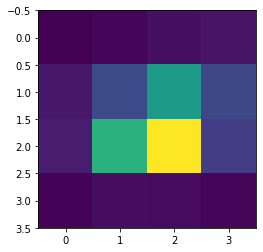

In [13]:
print(release_responses['bAP.MEA']['LFP'].shape)
lfp = release_responses['bAP.MEA']['LFP'].reshape(4, 4, 24001)
plt.imshow(numpy.max(numpy.abs(lfp), axis=-1))

In [ ]:
import pickle
original_responses = pickle.load(open("responses.pkl", "rb"))

fig, axes = plt.subplots(len(release_responses), figsize=(10,10))
for index, (resp_name, response) in enumerate(sorted(release_responses.items())):
    axes[index].plot(response['time'], response['voltage'], label=resp_name, lw=1.0, alpha=0.5)
    axes[index].plot(original_responses[resp_name]['time'], original_responses[resp_name]['voltage'], label=resp_name, lw=1.0, alpha=0.5)
    axes[index].set_title(resp_name)
fig.tight_layout()

for resp_name in release_responses:
    end = numpy.min([len(original_responses[resp_name]['time']), len(release_responses[resp_name]['time'])])
    _ = numpy.sum(numpy.abs(original_responses[resp_name]['time'][:end]-release_responses[resp_name]['time'][:end]))
    print(resp_name, _/end)
    print(release_responses[resp_name]['time'].iloc[-1], original_responses[resp_name]['time'].iloc[-1])
fig.show()

In [ ]:
#opt = bpopt.optimisations.DEAPOptimisation(                                     
#    evaluator=evaluator,                                                            
#    offspring_size=4) 
#final_pop, halloffame, log, hist = opt.run(max_ngen=4, cp_filename='checkpoints/checkpoint.pkl')

In [ ]:
#best_params = evaluator.param_dict(halloffame[0])
#print(pp.pprint(best_params))

In [ ]:
#best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)
#plot_responses(best_responses)

In [ ]:
# Check if the cell is loaded properly
#l5pc_cell.unfreeze(release_params)
#l5pc_cell.freeze(release_params)
#l5pc_cell.instantiate(sim=evaluator.sim)
#print(evaluator.sim.neuron.h.celsius)

In [ ]:
fig, axes = plt.subplots(len(release_responses), figsize=(10,10))
for index, (resp_name, response) in enumerate(sorted(release_responses.items())): 
    if index < 3:
        _ = numpy.abs(numpy.diff(release_responses[resp_name]['time'])[:1000]-numpy.diff(original_responses[resp_name]['time'])[:1000])
        axes[index].plot(release_responses[resp_name]['time'][1:1001], _, lw=1.0, alpha=0.7)
        axes[index].set_xlabel("Time (ms)")
        axes[index].set_ylabel("dt (ms)")
        axes[index].set_yscale('log')

In [ ]:
fig, axes = plt.subplots(len(release_responses), figsize=(10,10))
for index, (resp_name, response) in enumerate(sorted(release_responses.items())):    
    axes[index].plot(release_responses[resp_name]['time'][1:], numpy.diff(release_responses[resp_name]['time']), lw=1.0, alpha=0.7)
    axes[index].plot(original_responses[resp_name]['time'][1:], numpy.diff(original_responses[resp_name]['time']), lw=1.0, alpha=0.7)
    axes[index].set_xlabel("Time (ms)")
    axes[index].set_ylabel("dt (ms)")